# Example MSM for a ligand binding process

by Stefan Doerr

We demonstrate how to use the HTMD code for analysing a protein-ligand binding process

You can download the data and analysis file from the following links:

* [Datasets](http://pub.htmd.org/li198ha8nfoiw90y2/datasets.tar.gz). Warning: 3GB filesize.
* [Analysis script](./ligand-binding.py).

## Getting started

First we import the modules we are going to need for the tutorial

In [1]:
%pylab inline
from htmd import *

Populating the interactive namespace from numpy and matplotlib
Videos from the HTMD2015 workshops are available on the Acellera youtube channel: https://www.youtube.com/user/acelleralive

You are on the latest HTMD version (unpackaged).


## Creating a simulation list

For the purposes of an analysis, full atom information is required by HTMD. Therefore each simulation trajectory has to be associated with a corresponding PDB file. Additionally, if you plan to run adaptive, each trajectory needs to be associated with an input directory which contains the files used to run the simulations. The simList function allows us to make these associations

    sims = simlist(glob('data/*/'), glob('input/*/structure.pdb'), glob('input/*/'))

## Filtering trajectories

Typically waters are removed from the trajectories as they are not used in the analysis and it helps speed up further calculations. These filtered trajectories are written into a new directory. The advantage of filtering is that if your input structures only differ in the number of water molecules, you can produce a single unique pdb file for all simulations once you remove the waters, which will speed up calculations. This step is not necessary for the analysis and you can skip it if you don't mind the slowdown in calculations. In that case replace in the following commands the fsims variable with sims.

    fsims = simfilter(sims, './filtered/', filtersel='not water')

In this tutorial due to space limitations we provide only the filtered trajectories which are stored in three separate dataset folders. Therefore we will skip the above two commands and construct the simulation list directly from the filtered trajectories.

In [2]:
os.chdir('/webdata/li198ha8nfoiw90y2/')
sets = glob('datasets/*/')
sims = []
for s in sets:
    fsims = simlist(glob(s + '/filtered/*/'), 'datasets/1/filtered/filtered.pdb')
    sims = simmerge(sims, fsims)

2016-02-25 14:54:38,100 - htmd.simlist - INFO - Starting listing of simulations.
Creating simlist: 100% (230/230) [#################################] eta 00:00 -
2016-02-25 14:54:38,353 - htmd.simlist - INFO - Finished listing of simulations.
2016-02-25 14:54:38,498 - htmd.simlist - INFO - Starting listing of simulations.
Creating simlist: 100% (309/309) [#################################] eta 00:01 |
2016-02-25 14:54:38,862 - htmd.simlist - INFO - Finished listing of simulations.
2016-02-25 14:54:38,966 - htmd.simlist - INFO - Starting listing of simulations.
Creating simlist: 100% (314/314) [#################################] eta 00:00 -
2016-02-25 14:54:39,236 - htmd.simlist - INFO - Finished listing of simulations.


## Calculating metrics

To build a Markov state model we need to project the atom coordinates onto a lower dimensional space which can be used for clustering the conformations into a set of states. For protein systems we typically use the binary contact map between the carbon alpha atoms of the protein. This will calculate contacts between all carbon-alpha atoms. 

In [3]:
metr = Metric(sims)
metr.projection(MetricDistance('protein and name CA', 'resname MOL and noh', metric='contacts'))
data = metr.project()

2016-02-25 14:54:39,393 - htmd.projections.metric - INFO - Metric: Starting projection of trajectories.


[Parallel(n_jobs=-2)]: Done   1 out of 852 | elapsed:    0.2s remaining:  2.6min
[Parallel(n_jobs=-2)]: Done  74 out of 852 | elapsed:    1.5s remaining:   15.3s
[Parallel(n_jobs=-2)]: Done 152 out of 852 | elapsed:    2.6s remaining:   12.2s
[Parallel(n_jobs=-2)]: Done 230 out of 852 | elapsed:    3.9s remaining:   10.6s
[Parallel(n_jobs=-2)]: Done 308 out of 852 | elapsed:    5.2s remaining:    9.2s
[Parallel(n_jobs=-2)]: Done 386 out of 852 | elapsed:    6.5s remaining:    7.9s
[Parallel(n_jobs=-2)]: Done 464 out of 852 | elapsed:    7.9s remaining:    6.6s
[Parallel(n_jobs=-2)]: Done 542 out of 852 | elapsed:    9.2s remaining:    5.3s
[Parallel(n_jobs=-2)]: Done 620 out of 852 | elapsed:   10.4s remaining:    3.9s
[Parallel(n_jobs=-2)]: Done 698 out of 852 | elapsed:   11.6s remaining:    2.6s
[Parallel(n_jobs=-2)]: Done 776 out of 852 | elapsed:   12.8s remaining:    1.3s
[Parallel(n_jobs=-2)]: Done 852 out of 852 | elapsed:   14.1s finished


2016-02-25 14:54:53,661 - htmd.projections.metric - INFO - Finished projecting the trajectories.
2016-02-25 14:54:53,662 - htmd.projections.metric - INFO - Frame step 1e-06ns was read from the trajectories. If it looks wrong, redefine it by manually setting the MetricData.fstep property.


Here we provide the frame-step in nanoseconds i.e. the time that passes between two consecutive frames in a trajectory. This is automatically read from the trajectories, however some simulation software does not contain the correct fstep in the trajectories so it can be useful to manually define it like here.

In [4]:
data.fstep = 0.1

## Removing trajectories

Sometimes the set of trajectories can contain trajectories of incorrect length. These are typically corrupted trajectories and are removed.

plotTrajSizes plots all trajectory lengths sorted

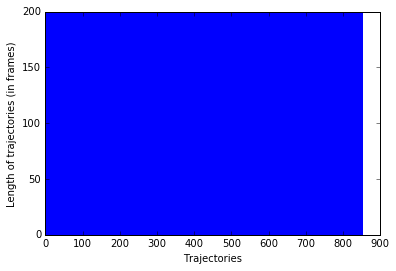

In [5]:
data.plotTrajSizes()

dropTraj has multiple options for removing simulations from the dataset. Here we use it to remove all trajectories whose length is not equal to the mode length. 

In [6]:
data.dropTraj()

2016-02-25 14:54:55,879 - htmd.metricdata - INFO - Dropped 2 trajectories from 852 resulting in 850


array([413, 479])

## TICA

TICA is a method that can be used to improve the clustering of the conformations. This is done by projecting the data onto a lower-dimensional space which separates well the metastable minima and places clusters on the transition regions. 

In [7]:
tica = TICA(data, 20)
dataTica = tica.project(3)

## Bootstrapping

If we want to bootstrap our calculations we can at this point drop a random 20% of the trajectories and do the rest of the analysis multiple times to see if the results are consistent. Alternatively we can keep on using dataTica in the following commands. 

In [8]:
dataBoot = dataTica.bootstrap(0.8)

## Clustering conformations

Once we have cleaned the dataset we proceed to cluster the conformations.

Here we use the mini-batch kmeans clustering algorithm to procude 1000 clusters. Clusters containing fewer than 5 conformations will get merged into their next neighbour with more than 5 conformations. 

In [9]:
dataBoot.cluster(MiniBatchKMeans(n_clusters=1000), mergesmall=5)

2016-02-25 14:57:19,364 - htmd.metricdata - INFO - Mergesmall removed 1 clusters. Original ncluster 980, new ncluster 979.


/shared/sdoerr/Software/anaconda3/lib/python3.4/site-packages/sklearn/cluster/k_means_.py:1273: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)


## Building the Markov model

After clustering it is time to build the Markov model.

In [10]:
model = Model(dataBoot)

Before constructing the Markov model we need to choose the lag-time at which it will be built. The lag-time is typically chosen by looking at the implied timescale (ITS) plot and selecting a lag-time at which the top timescales start converging. By constructing Markov models at various lag times HTMD creates a plot which shows the slowest implied timescales of each Markov model at various lag times. If a model is Markovian at a specific lag time, the implied timescales should stay unchanged for any higher lag times. Therefore, given an implied timescales plot, the user can monitor the convergence and choose the lag time at which to construct his Markov model, typically the Markov time which is the shortest lag time at which the timescales converge. Too large lag times can reduce the temporal resolution of the Markov model and can create more statistical uncertainty due to fewer transition counts and thus instability in the implied timescales. 

25-02-16 14:57:45 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[1] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


/shared/sdoerr/Software/anaconda3/lib/python3.4/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


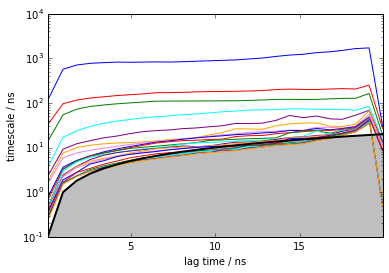

In [11]:
model.plotTimescales()

After seeing the ITS plot we decided on a lag-time of 50 frames (5ns). Additionally the ITS plot showed us that there is a separation between 4 slow timescales and the rest of the timescales which are fast. Therefore we choose to lump our microstates together into 5 macrostates. 

In [12]:
model.markovModel(50, 5)

2016-02-25 14:57:52,836 - htmd.model - INFO - 100.0% of the data was used
2016-02-25 14:57:52,918 - htmd.model - INFO - Number of trajectories that visited each macrostate:
2016-02-25 14:57:52,919 - htmd.model - INFO - [151  96 356 139 242]


## Visualizing the states

To see what the states look like we use a Matlab integration of VMD. We load the 3 macrostates and add a ligand representation using the ligand atomselection. 

In [13]:
model.viewStates(ligand='resname MOL and noh')

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    5.6s
[Parallel(n_jobs=1)]: Done   2 jobs       | elapsed:    6.3s
[Parallel(n_jobs=1)]: Done   3 jobs       | elapsed:    7.2s
[Parallel(n_jobs=1)]: Done   4 jobs       | elapsed:    8.0s
[Parallel(n_jobs=1)]: Done   5 jobs       | elapsed:    8.8s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.8s finished


## Calculating the kinetics

One of the major advantages of Markov state models is that they can provide quantitative results about the kinetics between states.

Provide the Kinetics constructor with the system temperature and ligand concentration. It automatically then calculates the source and sink states. 

In [14]:
kin = Kinetics(model, temperature=298, concentration=0.0037)

2016-02-25 14:58:08,893 - htmd.kinetics - INFO - Detecting source state...
2016-02-25 14:58:09,413 - htmd.kinetics - INFO - Guessing the source state as the state with minimum contacts.
2016-02-25 14:58:09,414 - htmd.kinetics - INFO - Source macro = 2
2016-02-25 14:58:09,414 - htmd.kinetics - INFO - Detecting sink state...
2016-02-25 14:58:09,414 - htmd.kinetics - INFO - Sink macro = 4


To see the rates between the source and sink states we use the getRates method.

In [15]:
r = kin.getRates()
print(r)

2016-02-25 14:58:09,418 - htmd.kinetics - INFO - Calculating rates between source: 2 and sink: 4 states.
2016-02-25 14:58:09,512 - htmd.kinetics - INFO - Concentration correction of -3.32 kcal/mol.
mfpton = 8.19E+02 (ns)
mfptoff = 5.80E+03 (ns)
kon = 3.30E+08 (1/M 1/s)
koff = 1.72E+05 (1/s)
koff/kon = 5.22E-04 (M)
kdeq = 3.99E-04 (M)
g0eq = -4.63 (kcal/mol)



To plot the free energies and mean first passage times of all state use the plotRates command.

2016-02-25 14:58:09,516 - htmd.kinetics - INFO - Calculating rates between source: 2 and sink: 0 states.
2016-02-25 14:58:09,608 - htmd.kinetics - INFO - Concentration correction of -3.32 kcal/mol.
2016-02-25 14:58:09,609 - htmd.kinetics - INFO - Calculating rates between source: 2 and sink: 1 states.
2016-02-25 14:58:09,699 - htmd.kinetics - INFO - Concentration correction of -3.32 kcal/mol.
2016-02-25 14:58:09,700 - htmd.kinetics - INFO - Calculating rates between source: 2 and sink: 3 states.
2016-02-25 14:58:09,786 - htmd.kinetics - INFO - Concentration correction of -3.32 kcal/mol.
2016-02-25 14:58:09,786 - htmd.kinetics - INFO - Calculating rates between source: 2 and sink: 4 states.
2016-02-25 14:58:09,867 - htmd.kinetics - INFO - Concentration correction of -3.32 kcal/mol.


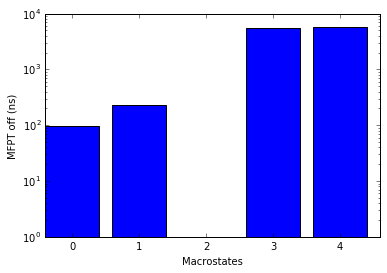

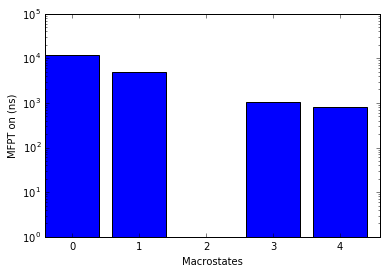

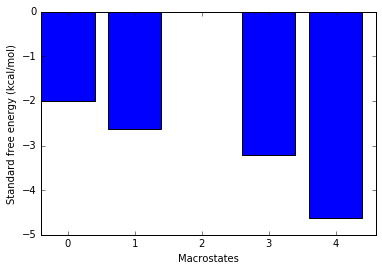

In [16]:
kin.plotRates()

Path flux		%path	%of total	path
0.0005359436632048044	64.2%	64.2%		[2 4]
0.00027404255710131116	32.9%	97.1%		[2 3 4]
2.3385886235518667e-05	2.8%	99.9%		[2 1 4]
8.236865006839771e-07	0.1%	100.0%		[2 1 3 4]


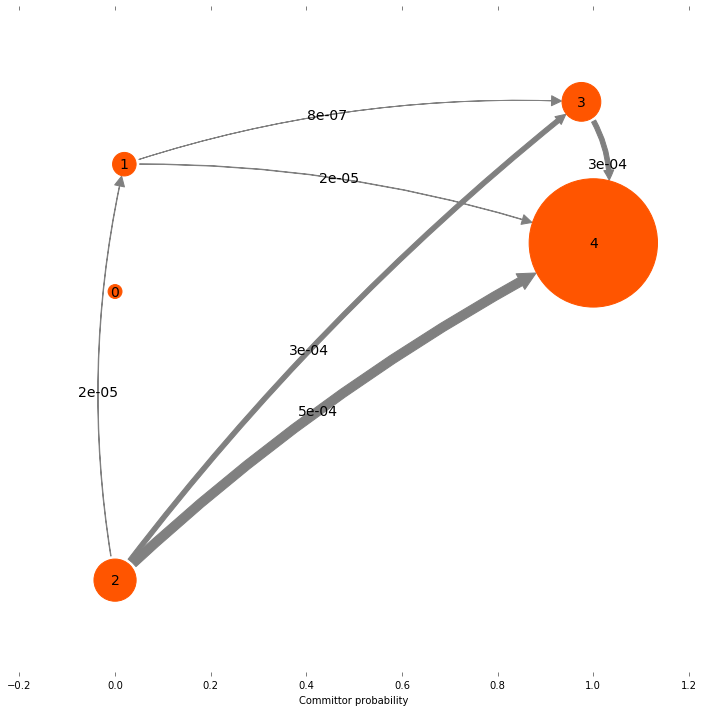

In [17]:
kin.plotFluxPathways()